<Body>   
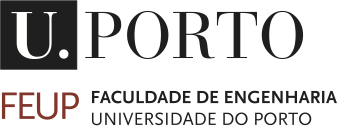   
<h1> <b>Machine Learning 2023/2024 (2<sup>nd</sup> semester) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt),
**Aníbal Matos** (anibal@fe.up.pt),
**Andry Pinto** (amgp@fe.up.pt),
**Daniel Campos** (dfcampos@fe.up.pt),
**Maria Inês Pereira** (maria.ines@fe.up.pt)

FEUP, Mar. 2024

---


# **Project #02**

**Note:** This work is to be done in group of **2** elements. Use this notebook to answer all the questions. At the end of the work, you should **upload** the **notebook** and a **pdf file** with a printout of the notebook with all the results in the **moodle** platform.
To generate the pdf file we have first to covert the notebook to html using the command `!jupyter nbconvert --to html "ML_project2.ipynb"`, then open the html file and printout to PDF.

**Deadlines:** Present you work (and answer questions) on the week of **May 20** in your corresponding practical class. Upload the files until 23:59 of **May 31, 2024**.


---



# **Identification**

* **Group:** Project_A02_A
* **Name:** Bárbara Fernades
* **Student Number:** 202004756

* **Name:** Raquel Carvalho
* **Student Number:** 202004516


---




**Initial setup:** To download the data files, run the next cell.

In [28]:
!jupyter nbconvert --to html "ML_project2.ipynb"

[NbConvertApp] Converting notebook ML_project2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 491983 bytes to ML_project2.html


In [14]:
!wget -O data-setMLproject2.zip https://www.dropbox.com/s/hnyhgqlj5lcqyqr/data-setMLproject2.zip?dl=0 --quiet
!unzip data-setMLproject2.zip -d.


Archive:  data-setMLproject2.zip
  inflating: ./data_test.csv         
  inflating: ./__MACOSX/._data_test.csv  
  inflating: ./data_test2obs.csv     
  inflating: ./__MACOSX/._data_test2obs.csv  
  inflating: ./data_train.csv        
  inflating: ./__MACOSX/._data_train.csv  


# **Main goal**

Consider the following scenario: A mobile robot aims to build a map of the environment with **semantics**, meaning that the robot should be capable to classify the objects nearby. The robot is travelling around and carries on-board a 2D LIDAR measurement device that obtains range measurements at each sample time $t=0, 0.1, 0.2, \ldots$ The following cell shows an example of the type of data:


In [15]:
import pandas as pd
df_test2obs = pd.read_csv('data_test2obs.csv', index_col=0)
df_test2obs.head(5)
#df

# By convention, zero values mean no range measurements.
# The units are:
# [m] for px and py (position of the robot)
# [m] for the LIDAR ranges

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 171,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180
0,-4.00,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-3.98,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.96,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-3.94,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.92,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note that the LIDAR measurements consist of range (distance) from the robot to a possible obstacle for each degree of direction, that is,
$$
r_t = \{r_\beta + \eta_r : \beta=-179^o, -178^o, \ldots, 0^o, \ldots, 180^o\}
$$
where $\eta_r$ is assumed to be Gaussian noise. If there is no obstacle within the direction of the laser range or if it is far away, that is, if the distance is greater than $5\,m$, by convention the range measurement is set to zero. Moreover, with a small probability, the range measurements could be corrupted with *outliers*.

The next figure shows $r_t$ as a function of the angle $\beta$ taken at time $t=1.0\,s$.


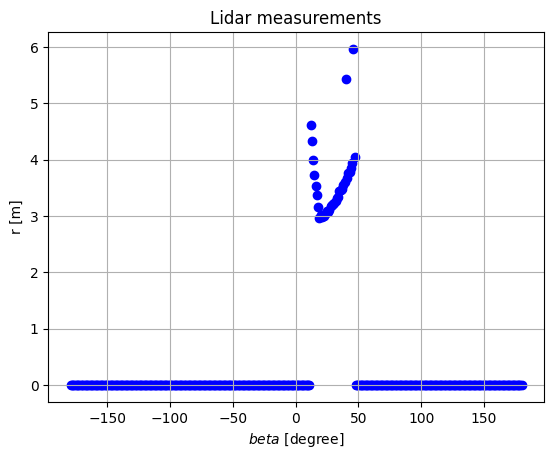

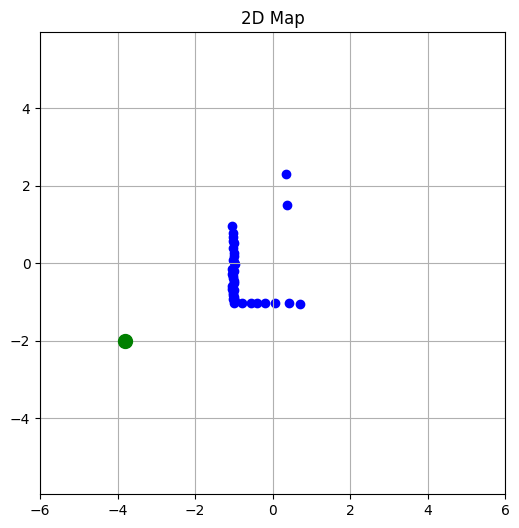

In [16]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt

Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

t=1*10 #1sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

Note that it may be possible to have more than one object in the range of the LIDAR. \\
Here goes an example when $t=32\,s$:


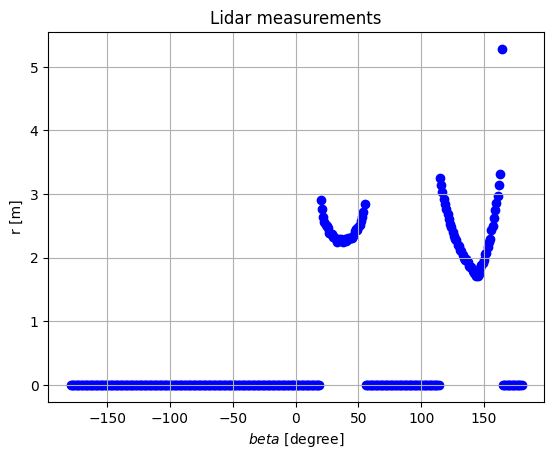

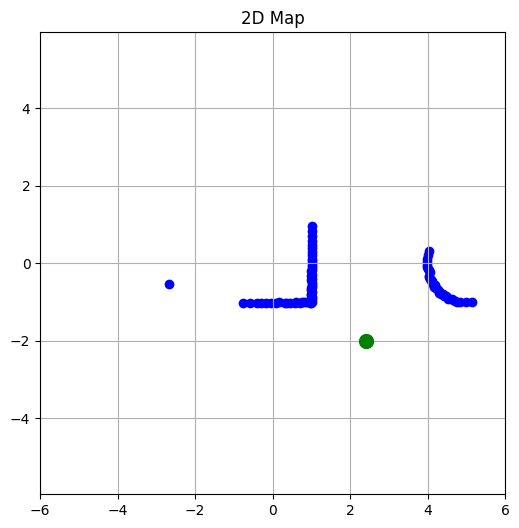

In [17]:
t=32*10 #5sec times number of samples/second
angle = np.linspace(-179, 180, num=360)

plt.figure()
plt.scatter(angle, Lidar_range[t], color='b')
plt.title('Lidar measurements')
plt.ylabel('r [m]')
plt.xlabel('$beta$ [degree]')
plt.grid();
plt.show()

#Build the cloud points in 2D plan
x_o, y_o = [], []
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
xdim, ydim = 5, 5
plt.xlim(-xdim-1,xdim+1)
plt.ylim(-ydim-1,ydim+1)
plt.plot(px[t], py[t], 'g.', ms=20)  #position of the robot
plt.grid()

plt.scatter(x_o, y_o, color='b')
plt.title('2D Map');
plt.show()

# **Part 1: Classification of one object**

At this point, the goal is to classify only one object that could be a square or a circle at each LIDAR snapshot. To this end, it was performed a set of 4 experiments for each obstacle (alone) where in each experiment the robot travelled during $40\,s$ with a constant speed and constant direction (horizontal line segment from left to right) from the initial position $(p_x, p_y) = (-4, \bar y)$ to the final position $(p_x, p_y) = (4, \bar y)$, where $\bar y = -4, -3, -2, -1\, m$ \\
The obstacle (circle and square) were placed at the center of the origin $(0,0)$. \\
All the experiments were combined in a unique dataset and then randomly split into two datasets: the trainning data set (70%) and the testing data set (30%). The content of each data set are displayed next.

In [18]:
import pandas as pd
df_train = pd.read_csv('data_train.csv', index_col=0)
df_train

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180,label
0,-3.06,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.48,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.58,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-3.10,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.48,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2.60,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2236,-2.12,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2237,-2.80,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2238,1.18,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [19]:
import pandas as pd
df_test = pd.read_csv('data_test.csv', index_col=0)
df_test

,px,py,angle -179,angle -178,angle -177,angle -176,angle -175,angle -174,angle -173,angle -172,...,angle 172,angle 173,angle 174,angle 175,angle 176,angle 177,angle 178,angle 179,angle 180,label
0,-3.46,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
1,0.38,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2,2.58,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
3,-2.84,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
4,-2.56,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,3.32,-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.752938,2.789123,2.869662,2.960473,3.041882,3.292784,0.0,0.0,0.0,1.0
956,3.62,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
957,2.20,-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.381054,1.557405,1.728042,2.111385,2.553902,0.000000,0.0,0.0,0.0,2.0
958,-2.98,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


Note that there is an extra column (the label column) that indicates if the obstacle is a **circle (label 1)** or a **square (label 2)**.

**1.1**
Implement a **$k$-nearest neighbor ($k$-NN)** classifier that receives the parameter $k$, the sample to classify (that are the range measurements at one snapshot), and a set of labeled training data. \\
Do not use sklearn or similar packages (use the results of notebook #7).

In [20]:
# Training data
X_train = df_train.iloc[:, np.arange(2, 362, 1)].values
Y_train = df_train["label"].values
data_train = df_train.iloc[:, np.arange(2, 363, 1)].values  # Including labels

# Function to calculate Euclidean distances
def vector2norm(x, data):
    npoints = data.shape[0]
    distances = np.zeros(npoints)

    for i in range(npoints):
        # Calculate the norm by comparing feature vectors of the same dimensions
        distances[i] = np.linalg.norm(x - data[i])  # Assuming columns 2 to 361 are LIDAR data
    return distances

def kNN_classifier(k, x, data):
  npoints = data.shape[0]
  # Compute distances to training points
  dist = vector2norm(x, data[:,:-1])
  # Sort indices of distances in ascending order
  ind = np.argsort(dist, axis=0)
  # Extract the classes of the k nearest neighbors
  classes = data[:,360]
  classes_sorted = classes[ind]

  # determine class with more element in the k neighborhood
  c1 = 0
  c2 = 0
  for i in range(k):
    if classes_sorted[i]==1:
      c1 +=1
    else:
      c2 +=1
  if c1>c2:
    return 1
  else:
    return 2

**1.2**
Test the $k$-NN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy for $k=1,3,5,7,9$ \\
Note that accuracy is defined as
$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives.


In [27]:
# Assuming kNN_classifier is defined elsewhere

# Combine X_train and Y_train into data_train
data_train = np.append(X_train, np.reshape(Y_train, (len(Y_train), 1)), axis=1)
k = [1, 3, 5, 7, 9]

classification_train = []

for ks in range(len(k)):
    classification = []
    for t in range(len(X_train)):
        classification.append(kNN_classifier(k[ks], X_train[t], data_train))
    classification_train.append(classification)

# Testing data
X_test = df_test.iloc[:, np.arange(2, 362, 1)].values
Y_test = df_test["label"].values

classification_test = []

for ks in range(len(k)):
    classification = []
    for t in range(len(X_test)):
        classification.append(kNN_classifier(k[ks], X_test[t], data_train))
    classification_test.append(classification)

# Convert lists to np arrays
classification_train = np.array(classification_train)
classification_test = np.array(classification_test)

# Printing the results
for ks in range(len(k)):
    TP_TN_train = 0
    TP_TN_test = 0

    for idx in range(len(Y_train)):
        if Y_train[idx] == classification_train[ks][idx]:
            TP_TN_train += 1

    for idx in range(len(Y_test)):
        if Y_test[idx] == classification_test[ks][idx]:
            TP_TN_test += 1

    acc_train = TP_TN_train / len(Y_train)
    acc_test = TP_TN_test / len(Y_test)
    print(f"{k[ks]}NN Training dataset - Accuracy of the model: {100.0*acc_train:4.2f}%")
    print(f"{k[ks]}NN Test dataset - Accuracy of the model: {100.0*acc_test:4.2f}%")

1NN Training dataset - Accuracy of the model: 100.00%
1NN Test dataset - Accuracy of the model: 100.00%
3NN Training dataset - Accuracy of the model: 99.87%
3NN Test dataset - Accuracy of the model: 99.48%
5NN Training dataset - Accuracy of the model: 99.64%
5NN Test dataset - Accuracy of the model: 99.27%
7NN Training dataset - Accuracy of the model: 99.82%
7NN Test dataset - Accuracy of the model: 99.69%
9NN Training dataset - Accuracy of the model: 99.78%
9NN Test dataset - Accuracy of the model: 99.58%


**1.3**
Implement an Artificial Neural Network (ANN) of the type multi-layer perceptron (MLP) with
1. an input layer that receives the first 10 nonzero range measurements (for each snapshot);  
2. one hidden layer with 5 neurons with activation functions of the type ReLU (rectified linear unit);
3. an output layer with 1 neuron with a sigmoid activation function;

4. a loss function of the type mean square error.

Train the ANN using the `data_train.csv` set. \\
**Do not use** PyTorch, TensorFlow or similar packages (check notebook #8). \\
**Tip:** It is important to shuffle the training data. You may get better results with non constant learning rate. A final loss below 0.05 is good!


In [ ]:
# To complete

import numpy as np
np.random.seed(42)

N_INPUTS = 10  #Number of inputs

def mse_loss(y_true, y_pred):
  return ((y_true - y_pred) ** 2).mean()

def sigmoid(x):
  return 1/(1+ np.exp(-x))

def deriv_sigmoid(x):
  fx = sigmoid(x)
  return fx*(1-fx)

# ReLu activation function:
def relu(x):
  return max(x,0)

# Derivative of ReLu
def deriv_relu(x):
  return x > 0

class NeuralNetwork:
  '''
  Structure of the neural network:
    - N_INPUTS inputs
    - a hidden layer with 5 neurons (h1, h2, h3, h4, h5)
    - an output layer with 1 neuron (o1)
  '''
  def __init__(self):
    # Biases
    self.b1 = np.random.random()
    self.b2 = np.random.random()
    self.b3 = np.random.random()
    self.b4 = np.random.random()
    self.b5 = np.random.random()
    self.bo = np.random.random()

    # # Weights
    self.w1o, self.w2o, self.w3o, self.w4o, self.w5o = np.random.random(5)
    self.wi1 = np.random.random(N_INPUTS)
    self.wi2 = np.random.random(N_INPUTS)
    self.wi3 = np.random.random(N_INPUTS)
    self.wi4 = np.random.random(N_INPUTS)
    self.wi5 = np.random.random(N_INPUTS)


  def feedforward(self, x):
    '''
    - x is a numpy array with N_INPUTS elements.
    '''
    # # Hidden layer
    self.sum_h1 = np.dot(self.wi1, x) + self.b1
    self.sum_h2 = np.dot(self.wi2, x) + self.b2
    self.sum_h3 = np.dot(self.wi3, x) + self.b3
    self.sum_h4 = np.dot(self.wi4, x) + self.b4
    self.sum_h5 = np.dot(self.wi5, x) + self.b5

    self.h1 = relu(self.sum_h1)
    self.h2 = relu(self.sum_h2)
    self.h3 = relu(self.sum_h3)
    self.h4 = relu(self.sum_h4)
    self.h5 = relu(self.sum_h5)

    # # Output layer
    self.sum_o1 = self.w1o*self.h1 + self.w2o*self.h2 + self.w3o*self.h3 + self.w4o*self.h4 + self.w5o*self.h5 + self.bo
    self.o1 = sigmoid(self.sum_o1)
    return self.o1


  def train(self, data, y_trues, learn_rate = 0.1, epochs = 500):
    '''
    - data is a (n x N_INPUTS) numpy array, n = # of samples in the dataset.
    - y_trues is a numpy array with n elements.
      Elements in y_true correspond to those in data.
    '''
    loss_prev = 10000  #loss_prev is the loss of the previous iteration
    for epoch in range(epochs):
      for x, y_true in zip(data, y_trues):

        # *************************************************
        # 1. Feedforward Step
        y_pred = self.feedforward(x)

        # *************************************************
        # 2. Backpropagation Step

        # Partial derivatives.
        d_L_d_ypred = -2 * (y_true - y_pred)

        # Output Layer:  Neuron o1
        d_ypred_d_w1o = self.h1 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w2o = self.h2 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w3o = self.h3 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w4o = self.h4 * deriv_sigmoid(self.sum_o1)
        d_ypred_d_w5o = self.h5 * deriv_sigmoid(self.sum_o1)

        d_ypred_d_bo = deriv_sigmoid(self.sum_o1)

        d_ypred_d_h1 = self.w1o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h2 = self.w2o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h3 = self.w3o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h4 = self.w4o * deriv_sigmoid(self.sum_o1)
        d_ypred_d_h5 = self.w5o * deriv_sigmoid(self.sum_o1)

        # Hidden Layer: Neuron h1
        d_h1_d_wi1 =  x * deriv_relu(self.sum_h1)
        d_h1_d_b1 = deriv_relu(self.sum_h1)

        # Hidden Layer: Neuron h2
        d_h2_d_wi2 =  x * deriv_relu(self.sum_h2)
        d_h2_d_b2 = deriv_relu(self.sum_h2)

        # Hidden Layer: Neuron h3
        d_h3_d_wi3 =  x * deriv_relu(self.sum_h3)
        d_h3_d_b3 = deriv_relu(self.sum_h3)

        # Hidden Layer: Neuron h4
        d_h4_d_wi4 =  x * deriv_relu(self.sum_h4)
        d_h4_d_b4 = deriv_relu(self.sum_h4)

        # Hidden Layer: Neuron h5
        d_h5_d_wi5 =  x * deriv_relu(self.sum_h5)
        d_h5_d_b5 = deriv_relu(self.sum_h5)

        # *************************************************
        # 3. Gradient Descent
        # Output Layer:  Neuron o1
        self.w1o -= learn_rate * d_L_d_ypred * d_ypred_d_w1o
        self.w2o -= learn_rate * d_L_d_ypred * d_ypred_d_w2o
        self.w3o -= learn_rate * d_L_d_ypred * d_ypred_d_w3o
        self.w4o -= learn_rate * d_L_d_ypred * d_ypred_d_w4o
        self.w5o -= learn_rate * d_L_d_ypred * d_ypred_d_w5o
        self.bo -= learn_rate * d_L_d_ypred * d_ypred_d_bo

        # Hidden Layer: Neuron h1
        self.wi1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_wi1
        self.b1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_b1

        # Hidden Layer: Neuron h2
        self.wi2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_wi2
        self.b2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_b2

        # Hidden Layer: Neuron h3
        self.wi3 -= learn_rate * d_L_d_ypred * d_ypred_d_h3 * d_h3_d_wi3
        self.b3 -= learn_rate * d_L_d_ypred * d_ypred_d_h3 * d_h3_d_b3

        # Hidden Layer: Neuron h4
        self.wi4 -= learn_rate * d_L_d_ypred * d_ypred_d_h4 * d_h4_d_wi4
        self.b4 -= learn_rate * d_L_d_ypred * d_ypred_d_h4 * d_h4_d_b4

        # Hidden Layer: Neuron h5
        self.wi5 -= learn_rate * d_L_d_ypred * d_ypred_d_h5 * d_h5_d_wi5
        self.b5 -= learn_rate * d_L_d_ypred * d_ypred_d_h5 * d_h5_d_b5

      # *************************************************
      # 4. Performance assessment (per epoch)
      if epoch % 5 == 0:
        y_preds = np.apply_along_axis(self.feedforward, 1, data)
        loss = mse_loss(y_trues, y_preds)
        print("Epoch %d  --> Loss: %.4f" % (epoch, loss))
# Uncomment this part to enable a nonconstant learning rate
        if loss > loss_prev:  #if loss did not decrease, let's decrease the learn_rate
          if learn_rate > 0.002:
            learn_rate = learn_rate*.9  #decrease 90% of the previous value
          print("I'm at epoch", epoch, "with new learn_rate: ", learn_rate)
        loss_prev = loss



# Create the ANN
model = NeuralNetwork()

# Build the Trainingset (with the first nonzero N_INPUTS ranges)
trainingset_X = np.zeros([len(Y_train), N_INPUTS])
for t in range(len(Y_train)):
  j=0
  for i in range(360):
    if X_train[t][i] > 0:
      if j < N_INPUTS:
        trainingset_X[t][j] = X_train[t][i]
        j +=1

# Trainingset: here the labels are 0 or 1
trainingset_Y = Y_train-1

#Shuffling the set...
from sklearn.utils import shuffle
trainingset_X, trainingset_Y = shuffle(trainingset_X, trainingset_Y, random_state=42)

# Train the ANN
model.train(trainingset_X, trainingset_Y, learn_rate = 0.1, epochs = 1000)

Epoch 0  --> Loss: 0.4999
Epoch 5  --> Loss: 0.2116
Epoch 10  --> Loss: 0.1859
Epoch 15  --> Loss: 0.1925
I'm at epoch 15 with new learn_rate:  0.09000000000000001
Epoch 20  --> Loss: 0.1873
Epoch 25  --> Loss: 0.1733
Epoch 30  --> Loss: 0.1711
Epoch 35  --> Loss: 0.1866
I'm at epoch 35 with new learn_rate:  0.08100000000000002
Epoch 40  --> Loss: 0.1702
Epoch 45  --> Loss: 0.1711
I'm at epoch 45 with new learn_rate:  0.07290000000000002
Epoch 50  --> Loss: 0.1647
Epoch 55  --> Loss: 0.1650
I'm at epoch 55 with new learn_rate:  0.06561000000000002
Epoch 60  --> Loss: 0.1618
Epoch 65  --> Loss: 0.1599
Epoch 70  --> Loss: 0.1593
Epoch 75  --> Loss: 0.1579
Epoch 80  --> Loss: 0.1567
Epoch 85  --> Loss: 0.1558
Epoch 90  --> Loss: 0.1547
Epoch 95  --> Loss: 0.1536
Epoch 100  --> Loss: 0.1522
Epoch 105  --> Loss: 0.1510
Epoch 110  --> Loss: 0.1493
Epoch 115  --> Loss: 0.1477
Epoch 120  --> Loss: 0.1469
Epoch 125  --> Loss: 0.1450
Epoch 130  --> Loss: 0.1399
Epoch 135  --> Loss: 0.1391
Epoch 

**1.4**
Test the ANN classifier for the `data_train.csv` set and for the `data_test.csv` set and obtain the respectively accuracy. Write in a brief sentence of the main conclusions about the classifiers (k-NN and ANN) until this point.




$\color{Red} R $ :

K-NN classifies new data points based on the majority class of their nearest neighbors in the training set. This approach is excellent when dealing with data similar to the training data, but struggles to deal with unseen or distant data points.

ANNs, on the other hand, learn patterns and relationships from the features of the data. This feature-based learning allows ANNs to generalize and make accuracy predictions even for data not explicitly present in the training set.

K-NN is performing better in this case, but as RNA is more generalizable, it should take less time.

In [ ]:
# To complete

#Evaluation with the Training set
classification = []
for t in range(len(Y_train)):
  classification.append(model.feedforward(trainingset_X[t]))
classification = np.array(classification)
error_clas = 0
for t in range(len(classification)):
  if (classification[t] >= 0.5) and (trainingset_Y[t] == 0):
    error_clas += 1
  if (classification[t] < 0.5) and (trainingset_Y[t] == 1):
    error_clas += 1
print("Number of misclassified samples in the training data: ", error_clas, "in", len(Y_train))
acc = (len(Y_train) - error_clas)/len(Y_train)
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

# Evaluation with Test_set
test_set_X = np.zeros([len(Y_test), N_INPUTS])

for t in range(len(Y_test)):
  j=0
  for i in range(360):
    if X_test[t][i] > 0:
      if j < N_INPUTS:
        test_set_X[t][j] = X_test[t][i]
        j +=1

# Trainingset: here the labels are 0 or 1
test_set_Y = Y_test-1

classification = []
for t in range(len(Y_test)):
  classification.append(model.feedforward(test_set_X[t]))
classification = np.array(classification)
error_clas = 0
for t in range(len(classification)):
  if (classification[t] >= 0.5) and (test_set_Y[t] == 0):
    error_clas += 1
  if (classification[t] < 0.5) and (test_set_Y[t] == 1):
    error_clas += 1
print("Number of misclassified samples in the test data: ", error_clas, "in", len(Y_test))
acc = (len(Y_test) - error_clas)/len(Y_test)
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Number of misclassified samples in the training data:  89 in 2240
Accuracy of the model: 96.03%
Number of misclassified samples in the test data:  43 in 960
Accuracy of the model: 95.52%


# **Part 2: Classification of two objects**

We would like now to use the previous ANN classifier to the data in `data_test2obs.csv` that may have two objects at the same snapshot. The idea is to before send the range measurements to the classifier, apply first a k-means at each snapshot to separate the data into two sub-sets such that each sub-set only contains data of one object. Then, send each subset of data to the ANN classifier.

**2.1**
Implement the k-means algorithm and test it for two snapshots **converted to the 2D map** (that is, the input data for the k-means is the 2D map) of the dataset `data_test2obs.csv` for
1. $t=1\,s$ (which has only one object) and
2. for $t=32\,s$ (which has 2 objects).

What can you conclude? \\
Do not use sklearn or similar packages (use the results of notebook #10).


$\color{Red} R $ :
The k-means algorithm was applied to two snapshots (t=1s and t=32s). In t=1s, the algorithm with two clusters assigned all points to a single cluster since there's only one object. In t=32s, the algorithm with two clusters assigned the points to two different clusters since there are two objects. We can conclude that the results depend heavily on the chosen number of clusters (in this case k=2).

For t=1s
Number of iterations 7


<ipython-input-11-323536671eb2>:71: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[col].scatter(X_func[:, 0], X_func[:, 1], s=3, c='grey', cmap='Set1')


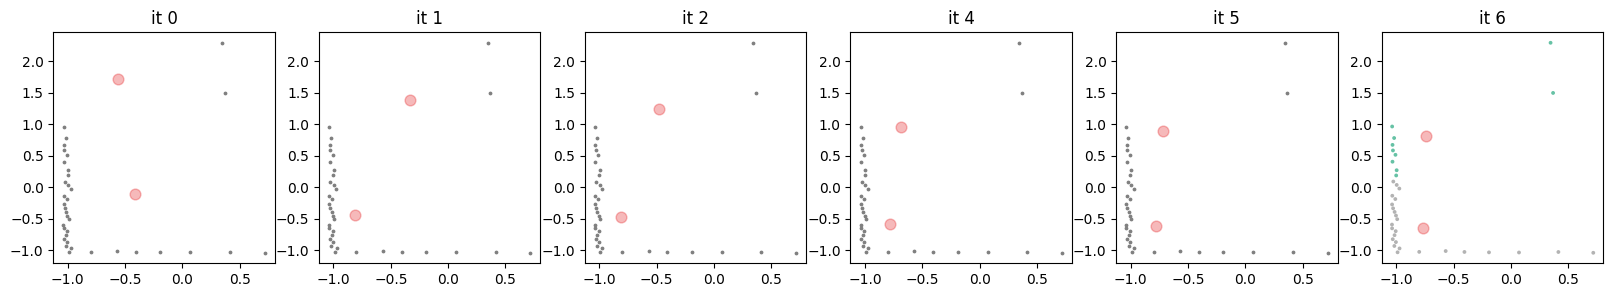

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
For t=32s
Number of iterations 2


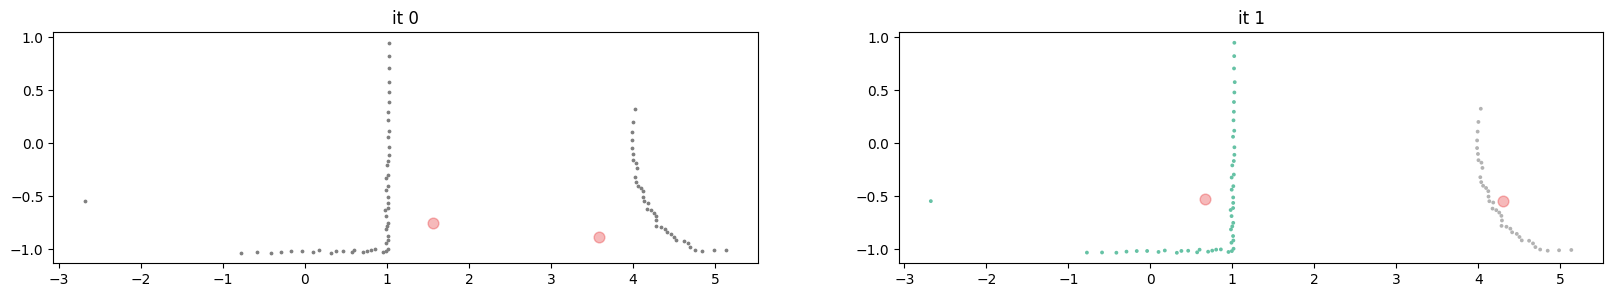

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# To complete

def kmeans_func(X_func, K_func, show_plot=0, ini_method=0):
  '''
    X_func are sample points;
    K_func is the number of clusters;
    showplot 0/1 - not / show centroid evolution over iterations;
    ini_method 0/1 - ini centroids 0=> with random within data bounderies or 1=>from the initial points (risky!)
  '''
  cluster = np.zeros(X_func.shape[0],dtype=int)
  centr_ini = []
  if ini_method:  # 1 is points, 0 is random
    # Initial centroids are sample points (risky!)
    for i in range(K_func):
      centr_ini.append(X_func[i])
  else:
    # Non absurd Random Initial Centroids
    max0 = max(X_func[:,0]);
    min0 = min(X_func[:,0]);
    max1 = max(X_func[:,1]);
    min1 = min(X_func[:,1]);

    for i in range(K_func):
      centr_ini.append([random.uniform(min0,max0),random.uniform(min1,max1)])

  iter = 0
  diff = 1
  centroids = centr_ini
  centr_list = [centroids]

  while diff:
    # for each sample
    for sample_i, sample_pt in enumerate(X_func):
      min_dist = float('inf')
      # dist of the point from all centroids
      for centroid_i, centroid in enumerate(centroids):
        dist = np.sqrt((centroid[0]-sample_pt[0])**2 + (centroid[1]-sample_pt[1])**2)
        # store closest centroid
        if min_dist > dist:
          min_dist = dist
          cluster[sample_i] = centroid_i
    ### may bug out ... new_centroids = pd.DataFrame(X_func).groupby(by=cluster).mean().values
    sum = np.zeros((K_func,2))
    cnt = np.zeros(K_func)
    for sample_i, sample_pt in enumerate(X_func):
      sum[cluster[sample_i]] += X_func[sample_i]
      cnt[cluster[sample_i]] += 1
    new_centroids = np.zeros((K_func,2))
    for k in range(K_func):
      if (cnt[k]>0):
        new_centroids[k] = sum[k] / cnt[k]
      else:
        # hopefully, the next iteration will fix uninteresting centroid
        new_centroids[k] = [random.uniform(min0,max0),random.uniform(min1,max1)]

    # if centroids are same then leave
    if np.count_nonzero(centroids-new_centroids) == 0:
      diff = 0
    else:
      centroids = new_centroids
      centr_list.append(new_centroids)
    iter=iter+1

  print("Number of iterations", iter)
  #print(centr_list)
  if show_plot: # pretty subplotting
    cols = min(iter,6) # max 6 plots
    fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(20,3))
    for col in range(min(cols,iter)):
      if col < min(cols,iter)-1:
        ax[col].scatter(X_func[:, 0], X_func[:, 1], s=3, c='grey', cmap='Set1')
      else:
        ax[col].scatter(X_func[:, 0], X_func[:, 1], s=3, c=cluster, cmap='Set2')
      i = round(iter/cols*col)
      if (col == cols-1):
        i = iter-1
      ## print("centr %s", i,"=>", centr_list[i])
      ## devia funcionar ### ax[row, col].scatter(centr_list[i][:,0], centr_list[i][:,1], c='black', s=200, alpha=0.5);
      for j in range(K_func):
        centr_plot_x = centr_list[i][j][0]
        centr_plot_y = centr_list[i][j][1]
        ##print("centr_plot", j, "=> ", centr_plot_x, centr_plot_y)
        ax[col].scatter(centr_plot_x, centr_plot_y, c=j, s=60, alpha=0.3, cmap='Set1')
        ax[col].title.set_text("it " + str(i) )
  plt.show()

  return centroids, cluster


#Build the cloud points in 2D map
x_o, y_o = [], []

print("For t=1s")
t=1*10
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T
centr, clust = kmeans_func(X, 2, show_plot=1, ini_method=0)
print(clust)

x_o, y_o = [], []

print("For t=32s")
t=32*10
for i in range(len(Lidar_range[t])):
  if Lidar_range[t][i] > 0:
    x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
    y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))

X = np.array([x_o, y_o]).T
centr, clust = kmeans_func(X, 2, show_plot=1, ini_method=0)
print(clust)

**2.2**
Using the previous results,
1. implement a method to automatically identify for each snapshot if it has 1 or 2 objects;
2. build a new test set with all the data in `data_test2obs.csv`, but now the new test set only has 1 object in each snapshot (and therefore this data set has more lines);
3. test this new data set using the ANN classifier.

Plot the position of the robot and the classified objects for some snapshots. What are the main conclusions?



$\color{Red} R $ :

We concluded from looking at the plots below that in almost all the classifications the ANN was able to classify the individual objects as circles or squares accurately.

However, there are some cases in which the classification is not performed in the most correct way, for example:

- At t=18s: A small circle is misclassified as a square;
- t=26s: An L-shaped circle is misclassified as a square;

These errors might be due to:

- Limited data: Few input points (from LiDAR);
- Robot position: The robot's relative position can affect captured data points;
- Inherent error: All machine learning models have a margin of error.

Number of iterations 2
Number of iterations 6
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 4
Number of iterations 2
Number of iterations 2
Number of iterations 3
Number of iterations 2
Number of iterations 2
Number of iterations 6
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 5
Number of iterations 2
Number of iterations 2
Number of iterations 11
Number of iterations 2
Number of iterations 2
Number of iterations 11
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 2
Number of iterations 3
Number of iterations 2
Number of iterations 2
Number of iterations 6
Number of iterations 2
Number of iterations 2
Number of iterations 7
Number of iterations 2
Number of iterations 2
Number of

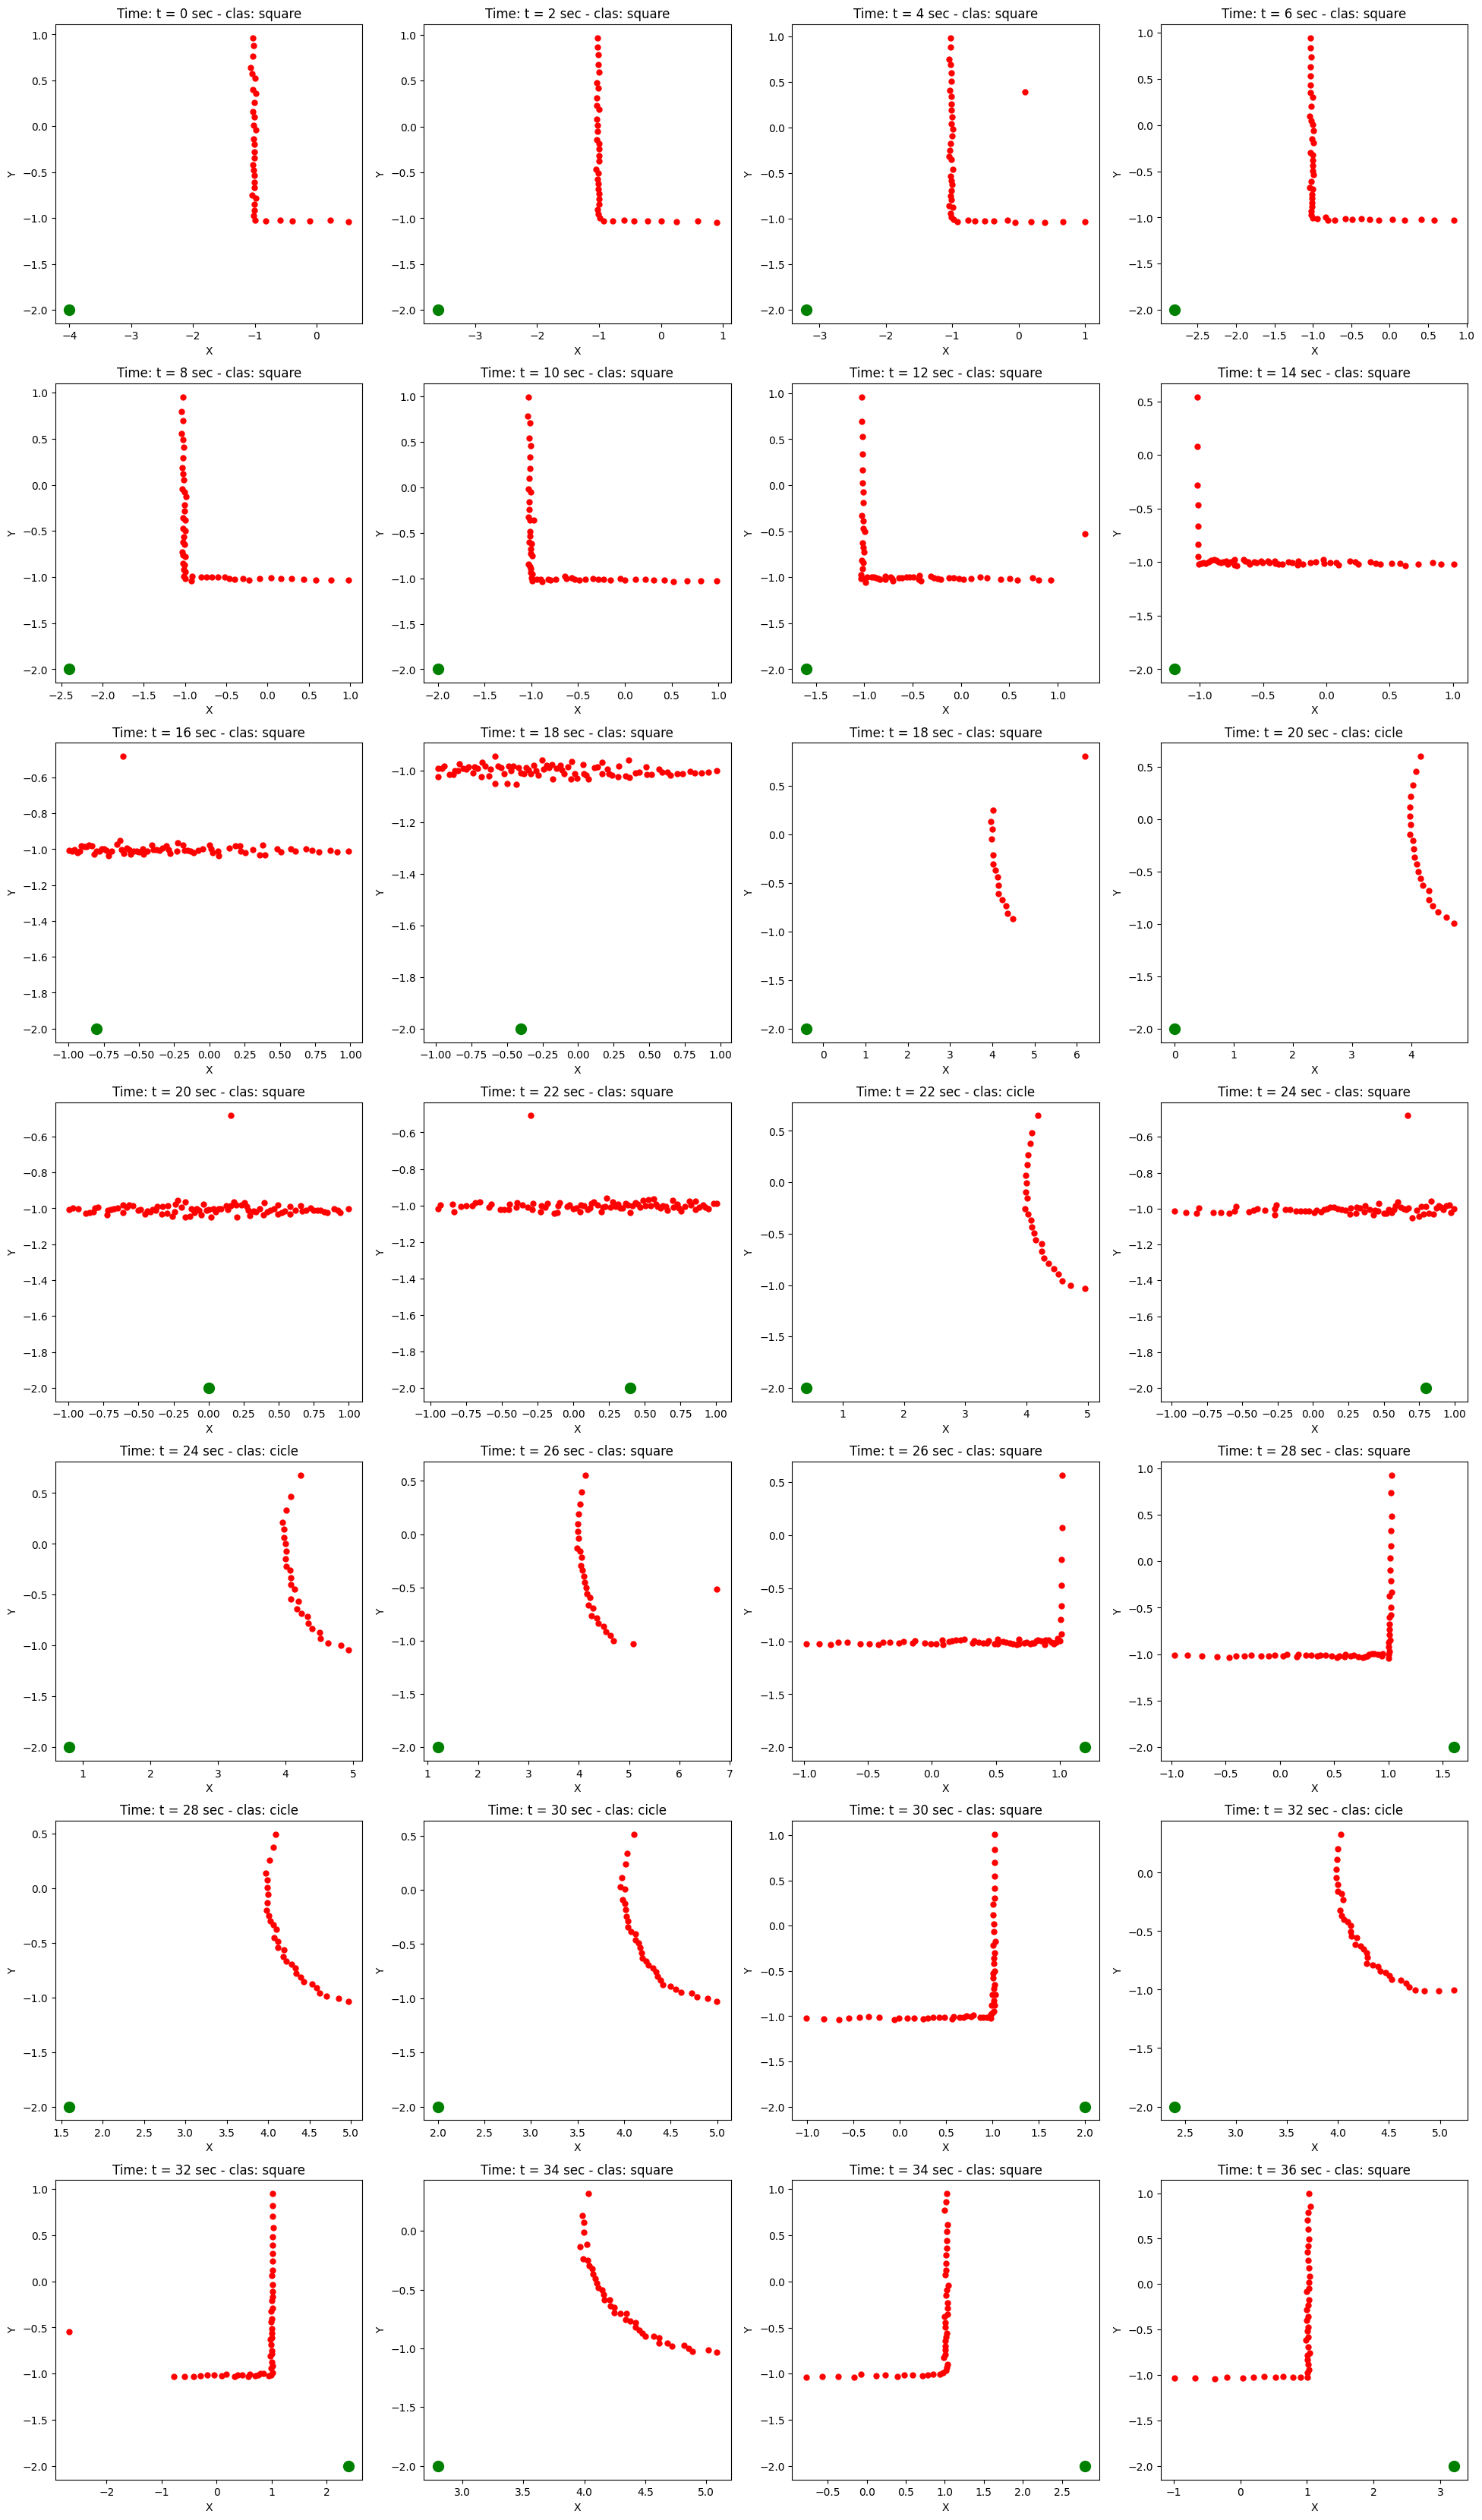

In [ ]:
# To complete

Threshold = 25 # to decide if k=1 or k=2,

Lidar_range = df_test2obs.iloc[:, np.arange(2,362,1)].values
px = df_test2obs["px"].values
py = df_test2obs["py"].values

def SSE(X, centroids, cluster):
  '''
    returns the Sum of Squared Error
    X are the 2D points
    centroids are the cluster centers
    cluster is the cluster that each data point belongs to
  '''
  sum = 0
  for i, val in enumerate(X):
    sum += np.sqrt((centroids[cluster[i], 0]-val[0])**2 +(centroids[cluster[i], 1]-val[1])**2)  ####
  return sum

# Building the data set for ANN testing using k-means to split objects

test_set_X = np.array([])
# ...
clust_time = [] # [t, px, py]
clust_object = [] #full clusters

for t in range(len(px)):
  #Build the cloud points in 2D map

  x_o, y_o = [], []
  x_o_clust1, y_o_clust1 = [], []
  x_o_clust2, y_o_clust2 = [], []

  for i in range(len(Lidar_range[t])):
    if Lidar_range[t][i] > 0:
      x_o.append(px[t]+Lidar_range[t][i]*np.cos(angle[i]/180*np.pi))
      y_o.append(py[t]+Lidar_range[t][i]*np.sin(angle[i]/180*np.pi))


  X = np.array([x_o, y_o]).T
  cost_list = []
  k_range = range(1, 3)
  for k in k_range:
    centr, clust = kmeans_func(X, k, show_plot=0, ini_method=0)
    # Calculate SSE
    cost = SSE(X, centr, clust)
    cost_list.append(cost)
  #Let's now decide if this snapshot has 1 or 2 obstacles

  if cost_list[0] - cost_list[1] > Threshold:
    #2 objects
    k = 2

    centr, clust = kmeans_func(X, k, show_plot=0, ini_method=0)

    X_feature1, X_feature2 = np.zeros([N_INPUTS]), np.zeros([N_INPUTS])
    j1,j2=0,0

    for i in range(len(x_o)):

      if clust[i] == 0:
        x_o_clust1.append(x_o[i])
        y_o_clust1.append(y_o[i])

      if clust[i] == 1:
        x_o_clust2.append(x_o[i])
        y_o_clust2.append(y_o[i])

      if j1 < N_INPUTS:
        if clust[i] == 0:
          X_feature1[j1]=np.sqrt((x_o[i]-px[t])**2 + (y_o[i]-py[t])**2)
          j1=j1+1

      if j2 < N_INPUTS:
        if clust[i] == 1:
          X_feature2[j2]=np.sqrt((x_o[i]-px[t])**2 + (y_o[i]-py[t])**2)
          j2=j2+1

    clust_time.append([t*0.1, px[t], py[t]])
    clust_time.append([t*0.1, px[t], py[t]])
    clust_object.append([[x_o_clust1], [y_o_clust1]])
    clust_object.append([[x_o_clust2], [y_o_clust2]])

    if len(test_set_X) == 0:
      test_set_X = np.array([X_feature1, X_feature2])

    else:
      test_set_X = np.concatenate((test_set_X,np.array([X_feature1, X_feature2])))

  else:
    #only one object
    k = 1

    centr, clust = kmeans_func(X, k, show_plot=0, ini_method=0)

    X_feature1 = np.zeros([N_INPUTS])
    j1=0

    for i in range(len(x_o)):

      if clust[i] == 0:
        x_o_clust1.append(x_o[i])
        y_o_clust1.append(y_o[i])

      if j1 < N_INPUTS:
        if clust[i] == 0:
          X_feature1[j1]=np.sqrt((x_o[i]-px[t])**2 + (y_o[i]-py[t])**2)
          j1=j1+1

    clust_time.append([t*0.1, px[t], py[t]])
    clust_object.append([[x_o_clust1], [y_o_clust1]])

    if len(test_set_X) == 0:
      test_set_X = np.array([X_feature1])
    else:
      test_set_X = np.concatenate((test_set_X,np.array([X_feature1])))

clas = []
time = []
res = []

for t in range(len(test_set_X)):
  class_val = model.feedforward(test_set_X[t])
  clas.append(class_val)
  time.append(clust_time[t][0])

  if(class_val >= 0.5):
    res.append([clust_time[t][0], clust_time[t][1], [clust_time[t][2]], clust_object[t][0], clust_object[t][1], 2, "square"])

  if(class_val < 0.5):
    res.append([clust_time[t][0], clust_time[t][1], [clust_time[t][2]], clust_object[t][0], clust_object[t][1], 1, "cicle"])

time = np.array(time);
t_plot = np.arange(0,60,2)

ncols = 4
nlines = (int)(len(t_plot)/ncols) #2 in 2 seconds
fig, ax = plt.subplots(nlines, ncols, figsize=(6*ncols,6*nlines))

l, c = 0, 0
cont = 0
t_idx=0

while(cont < ncols*nlines):
  t_index = np.where(t_plot[t_idx] == time) #get time index
  size = len(t_index[0]) #get number of objects for a time

  #first object
  t = t_index[0][0]

  ax[l][c].plot(res[t][1], res[t][2], 'g', marker=".", markersize=20)
  ax[l][c].plot(np.array(res[t][3]), np.array(res[t][4]), 'r', marker=".", markersize=10)
  ax[l][c].set_title(f"Time: t = {t_plot[t_idx]} sec - clas: {res[t][6]}")
  ax[l][c].set_xlabel("X")
  ax[l][c].set_ylabel("Y")

  #update indices
  cont += 1
  if(c == 3):
    c = 0
    l += 1
  else:
    c += 1

  if(cont >= ncols*nlines):
    break

  if(size == 2):
    #second object
    t = t_index[0][1]

    ax[l][c].plot(res[t][1], res[t][2], 'g', marker=".", markersize=20)
    ax[l][c].plot(np.array(res[t][3]), np.array(res[t][4]), 'r', marker=".", markersize=10)
    ax[l][c].set_title(f"Time: t = {t_plot[t_idx]} sec - clas: {res[t][6]}")
    ax[l][c].set_xlabel("X")
    ax[l][c].set_ylabel("Y")

    #update indices
    cont += 1
    if(c == 3):
      c = 0
      l += 1
    else:
      c += 1

  t_idx += 1




**2.3 (Extra)**
Using now PyTorch or other similar package, implement a better ANN (meaning with a better accuracy) and test it.

**Note:** This question is optional. If you solve it, you get extra 15 points (in 100).

In [ ]:
# To complete

import torch
import torch.nn as nn
import torch.nn.functional as F

class XOR_Classifier_Module(nn.Module):
  def __init__(self, num_inputs, num_hidden, num_outputs):
    super().__init__()
    # Initialize the modules we need to build the network
    self.linear1 = nn.Linear(num_inputs, num_hidden)
    self.activation_f1 = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, num_hidden)
    self.activation_f2 = nn.ReLU()
    self.linear3 = nn.Linear(num_hidden, num_hidden)
    self.activation_f3 = nn.ReLU()
    self.linear4 = nn.Linear(num_hidden, num_hidden)
    self.activation_f4= nn.ReLU()
    self.linear5 = nn.Linear(num_hidden, num_outputs)
    self.activation_sig = nn.Sigmoid()
    #  COMMENT if nn.BCEWithLogitsLoss is selected.
  def forward(self, x):
    # Perform the calculation of the model to determine the prediction
    x = self.linear1(x)
    x = self.activation_f1(x)
    x = self.linear2(x)
    x = self.activation_f2(x)
    x = self.linear3(x)
    x = self.activation_f3(x)
    x = self.linear4(x)
    x = self.activation_f4(x)
    x = self.linear5(x)
    x = self.activation_sig(x)
    return x
#  COMMENT if nn.BCEWithLogitsLoss is selected.
model = XOR_Classifier_Module(num_inputs=10, num_hidden=5, num_outputs=1)
# Printing a module shows all its submodules
print(model)

XOR_Classifier_Module(
  (linear1): Linear(in_features=10, out_features=5, bias=True)
  (activation_f1): ReLU()
  (linear2): Linear(in_features=5, out_features=5, bias=True)
  (activation_f2): ReLU()
  (linear3): Linear(in_features=5, out_features=5, bias=True)
  (activation_f3): ReLU()
  (linear4): Linear(in_features=5, out_features=5, bias=True)
  (activation_f4): ReLU()
  (linear5): Linear(in_features=5, out_features=1, bias=True)
  (activation_sig): Sigmoid()
)


In [ ]:
# Specific model parameters
for name, param in model.named_parameters():
  print(f"Parameter {name}, shape {param.shape}")
# All model parameter
model.state_dict()
#PyTorch assigns random values to these weights and biases

Parameter linear1.weight, shape torch.Size([5, 10])
Parameter linear1.bias, shape torch.Size([5])
Parameter linear2.weight, shape torch.Size([5, 5])
Parameter linear2.bias, shape torch.Size([5])
Parameter linear3.weight, shape torch.Size([5, 5])
Parameter linear3.bias, shape torch.Size([5])
Parameter linear4.weight, shape torch.Size([5, 5])
Parameter linear4.bias, shape torch.Size([5])
Parameter linear5.weight, shape torch.Size([1, 5])
Parameter linear5.bias, shape torch.Size([1])


OrderedDict([('linear1.weight',
              tensor([[-0.0830,  0.2838,  0.1227,  0.1875,  0.2200,  0.0933,  0.1605,  0.0441,
                        0.2894, -0.2783],
                      [-0.1784,  0.0098, -0.1586, -0.2786, -0.1316, -0.2646, -0.3144, -0.0425,
                        0.2721, -0.2365],
                      [-0.0333, -0.0775,  0.1531, -0.2126, -0.0531,  0.2255, -0.2841,  0.0381,
                        0.2614,  0.0889],
                      [ 0.2745,  0.1811,  0.1455, -0.2871,  0.1528,  0.2139,  0.0602,  0.0695,
                       -0.0667,  0.0060],
                      [-0.1089, -0.0371, -0.0500, -0.0948, -0.2411,  0.2846, -0.0191, -0.2976,
                       -0.3078,  0.2039]])),
             ('linear1.bias',
              tensor([-0.1021, -0.0878,  0.1144,  0.1835,  0.1950])),
             ('linear2.weight',
              tensor([[ 0.1096,  0.3379,  0.0501, -0.0636,  0.0204],
                      [ 0.1196,  0.0371, -0.2664,  0.2695,  0.1546],
          

In [ ]:
import torch.utils.data as data

SEED = 12340
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#define dataset class
class Dataset(data.Dataset):

    def __init__(self, size, X, Y):
        super().__init__()
        self.size = size
        self.generate_data(X, Y)

    def generate_data(self, X, Y):
        self.data = torch.from_numpy(X).to(torch.float32)
        self.label = torch.from_numpy(Y).to(torch.long)

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label


#create dataset
dataset = Dataset(len(trainingset_X), trainingset_X, trainingset_Y)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])


Size of dataset: 2240
Data point 0: (tensor([2.9153, 2.7820, 2.7273, 2.7058, 2.6226, 2.5617, 2.5449, 2.5148, 2.4817,
        2.4281]), tensor(0))


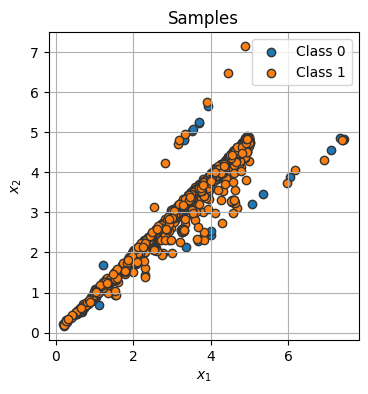

In [ ]:
import matplotlib.pyplot as plt
def visualize_samples(data, label):
  if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
  if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  plt.figure(figsize=(4,4))
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
  plt.title("Samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend(loc="upper right")

visualize_samples(dataset.data, dataset.label)

plt.grid()
plt.show()

In [ ]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))
# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 10]) 
 tensor([[2.8505, 2.6889, 2.6160, 2.5801, 2.4626, 2.4642, 2.3870, 2.3394, 2.3718,
         2.3301],
        [2.2746, 2.1655, 2.1418, 2.0426, 1.9553, 1.9749, 1.9117, 1.9257, 1.8835,
         1.8157],
        [2.2424, 2.0652, 2.0124, 2.9077, 1.8978, 1.8255, 1.7882, 1.7588, 1.7322,
         1.7196],
        [3.7755, 3.6353, 3.5373, 3.4312, 3.3984, 3.3708, 3.3086, 3.2379, 3.2228,
         3.2440],
        [3.5559, 3.4466, 3.3383, 3.2686, 3.1974, 3.1288, 3.1085, 3.0976, 3.0494,
         3.0327],
        [3.0552, 2.9393, 2.8909, 2.7956, 2.7325, 2.6474, 2.6542, 2.5808, 2.6222,
         2.5322],
        [2.9932, 3.0197, 2.9920, 3.0023, 2.9820, 2.9882, 2.9516, 3.0038, 2.9957,
         2.9959],
        [4.1879, 4.0359, 3.9290, 3.9181, 3.8169, 3.7974, 3.7791, 3.6962, 5.5199,
         5.5401]])
Data labels torch.Size([8]) 
 tensor([0, 0, 0, 0, 0, 0, 1, 0])


In [ ]:
loss_module =  nn.BCELoss() # or nn.BCEWithLogitsLoss()  nn.BCELoss()
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
# Push model to device. Has to be only done once
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or CUDA
model.to(device)

The model will be running on cpu device


XOR_Classifier_Module(
  (linear1): Linear(in_features=10, out_features=5, bias=True)
  (activation_f1): ReLU()
  (linear2): Linear(in_features=5, out_features=5, bias=True)
  (activation_f2): ReLU()
  (linear3): Linear(in_features=5, out_features=5, bias=True)
  (activation_f3): ReLU()
  (linear4): Linear(in_features=5, out_features=5, bias=True)
  (activation_f4): ReLU()
  (linear5): Linear(in_features=5, out_features=1, bias=True)
  (activation_sig): Sigmoid()
)

In [ ]:
from tqdm.notebook import trange, tqdm

def train_model(model, optimizer, dataloader, loss_criteria, num_epochs=1000):
  # Set model to train mode
  model.train()

  # Training loop
  for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for data_inputs, data_labels in dataloader:

      ## Step 0 (needed in case of GPU): Move input data to device
      data_inputs = data_inputs.to(device)
      data_labels = data_labels.to(device)

      # Step 1: setting gradients to zero. The gradients would not be overwritten but actually added to the existing ones.
      optimizer.zero_grad()

      ## Step 2: Run the model on the input data
      preds = model(data_inputs)
      preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
      #preds = torch.sigmoid(preds)  # UNCOMMNET if nn.BCEWithLogitsLoss is selected.  Sigmoid to map predictions between 0 and 1. Be aware that the l

      ## Step 3: Calculate the loss
      loss = loss_criteria(preds, data_labels.float())

      ## Step 4: Perform backpropagation
      loss.backward()

      ## Step 5: Update parameters based on the calculated gradients
      optimizer.step()

      ## Step 6: Take the running average of the loss
      epoch_loss += loss.item()
      # Add average loss to TensorBoard
    epoch_loss /= len(data_loader)
    if epoch % 5 == 0:
      print('[%d] loss: %.3f' % (epoch + 1, epoch_loss))

train_model(model, optimizer, data_loader, loss_module)


  0%|          | 0/1000 [00:00<?, ?it/s]

[1] loss: 0.463
[6] loss: 0.419
[11] loss: 0.658
[16] loss: 0.399
[21] loss: 0.412
[26] loss: 0.383
[31] loss: 0.417
[36] loss: 0.309
[41] loss: 0.258
[46] loss: 0.240
[51] loss: 0.289
[56] loss: 0.249
[61] loss: 0.271
[66] loss: 0.244
[71] loss: 0.246
[76] loss: 0.211
[81] loss: 0.244
[86] loss: 0.205
[91] loss: 0.247
[96] loss: 0.293
[101] loss: 0.215
[106] loss: 0.204
[111] loss: 0.198
[116] loss: 0.214
[121] loss: 0.183
[126] loss: 0.308
[131] loss: 0.204
[136] loss: 0.171
[141] loss: 0.248
[146] loss: 0.344
[151] loss: 0.218
[156] loss: 0.258
[161] loss: 0.228
[166] loss: 0.288
[171] loss: 0.162
[176] loss: 0.185
[181] loss: 0.166
[186] loss: 0.174
[191] loss: 0.261
[196] loss: 0.258
[201] loss: 0.145
[206] loss: 0.333
[211] loss: 0.155
[216] loss: 0.162
[221] loss: 0.178
[226] loss: 0.160
[231] loss: 0.212
[236] loss: 0.216
[241] loss: 0.186
[246] loss: 0.167
[251] loss: 0.192
[256] loss: 0.200
[261] loss: 0.152
[266] loss: 0.172
[271] loss: 0.150
[276] loss: 0.150
[281] loss: 0.

In [ ]:
def eval_model(model, data_loader):
  # Set model to eval mode
  model.eval()
  true_preds, num_preds = 0., 0.

  # Deactivate gradients for the following code
  with torch.no_grad():
    # get batch of images from the test DataLoader
    for data_inputs, data_labels in data_loader:
      ## Step 0 (needed in case of GPU): Move input data to device
      data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

      # Step 1: determine prediction of model
      preds = model(data_inputs)
      preds = preds.squeeze(dim=1)
      # Output is [Batch size, 1], but we want [Batch size]
      #preds = torch.sigmoid(preds)  # UNCOMMNET if nn.BCEWithLogitsLoss is selected.  Sigmoid to map predictions between 0 and 1. Be aware that the l

      # Step 2: Binarize predictions to 0 and 1
      pred_labels = (preds >= 0.5).long()

      # Step 3: Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
      true_preds += (pred_labels == data_labels).sum()
      num_preds += data_labels.shape[0]

  acc = true_preds / num_preds
  print(f"Accuracy of the model: {100.0*acc:4.2f}%")

eval_model(model, data_loader)

Accuracy of the model: 95.58%
